### MNIST Model and Misclassified Images

In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import alibi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


In [2]:
print(alibi.__version__)

0.7.0


In [3]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
#plt.imshow(x_test[15]);

x_train shape: (60000, 28, 28) y_train shape: (60000,)


<Figure size 432x288 with 0 Axes>

In [4]:
# loading etc
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [5]:
#normalizing
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

### Evaluate MC-Model on Test Set

In [6]:
cnn=load_model('cnn_mnist.h5')
cnn_mc = load_model('cnn_mnist_mc.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.9893


In [7]:
y_pred = cnn.predict(x_test)

In [8]:
misclassification_indices = list(np.where(np.argmax(y_pred, axis=1) != np.argmax(y_test, axis=1))[0]) #misclassifications

In [9]:
misclassified_images = []

for index in misclassification_indices:
    misclassified_images.append(x_test[index])
    

In [10]:
misclassified_images = np.array(misclassified_images)
misclassified_images.shape #i.e network misclassifies 107 28x28 mnist images

(107, 28, 28, 1)

In [11]:
def truetest(instance):
    plt.imshow(x_test[instance])
    return print("The black-box classifier is {} % sure this is a image of a {}. True Label = {}".format((np.round(cnn.predict(x_test[instance].reshape(1,28,28,1)).max()*100,2)), cnn.predict(x_test[instance].reshape(1,28,28,1)).argmax(), np.argmax(y_test[instance])))

The black-box classifier is 50.39 % sure this is a image of a 9. True Label = 7


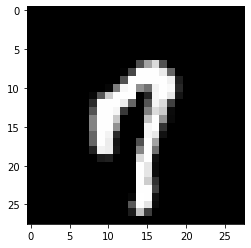

In [12]:
truetest(misclassification_indices[33])

In [13]:
#np.save('misclassified_image_set.npy', misclassified_images)

In [14]:
import scipy

##### Screwball Un-scramble: (Randomly ordered for psychological experiment)

In [15]:
user_explanations = np.load('user_explanations_g1.npy')
user_explanations_g2 = np.load('user_explanations_g2.npy')

In [16]:
misclassified_user_sample_indices = np.load('user_sample_indices.npy')
misclassified_user_sample = np.array([x_test[index] for index in misclassified_user_sample_indices])

In [17]:
mean_l1 = []
mean_l2 = []

for instance in range(50):
    
    l1=[]
    
    l2 = []
    
    for user in range(21):
        l1.append(scipy.spatial.distance.cityblock(misclassified_user_sample[instance].flatten(), user_explanations[user][instance].flatten()))
        l2.append(scipy.spatial.distance.euclidean(misclassified_user_sample[instance].flatten(), user_explanations[user][instance].flatten()))
    mean_l1.append(np.mean(np.mean(l1)))
    mean_l2.append(np.mean(np.mean(l2)))

In [18]:
mean_l1_g2 = []
mean_l2_g2 = []

for instance in range(50):
    
    l1_g2=[]
    l2_g2 = []
    
    for user in range(0,21):
        l1_g2.append(scipy.spatial.distance.cityblock(misclassified_user_sample[instance].flatten(), user_explanations_g2[user][instance].flatten()))
        l2_g2.append(scipy.spatial.distance.euclidean(misclassified_user_sample[instance].flatten(), user_explanations_g2[user][instance].flatten()))
    mean_l1_g2.append(np.mean(np.mean(l1_g2)))
    mean_l2_g2.append(np.mean(np.mean(l2_g2)))

In [19]:
nun_counterfactual_user = np.load('nun_cf_mnist_user.npy')
proto_counterfactual_user = np.load('proto_cf_mnist.npy')

In [20]:
wachter_cf = np.load('wachter_cf.npy')


In [21]:
cem_cf = np.load('../ICLR_22/CEM_mnist.npy')
revise_cf_user = np.load('../../../../../DeDUCE-master/DeDUCE-master/REVISE_cfe.npy')
jmsa_cf_user = np.load('../../../../../DeDUCE-master/DeDUCE-master/JMSA_cfe.npy')
rl_cf_user = np.load('../ICLR_22/cfe_RL.npy')

In [22]:
l1_nun_cf = []
l1_proto_cf = []
l1_wachter_cf = []
l1_cem_cf = []
l1_revise_cf = []

l2_nun_cf = []
l2_proto_cf = []
l2_wachter_cf = []
l2_cem_cf = []
l2_revise_cf = []


for image in range(0,50):
    
    l1_nun_cf.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), nun_counterfactual_user[image].flatten()))
    l1_proto_cf.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), proto_counterfactual_user[image].flatten()))
    l1_wachter_cf.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), wachter_cf[image].flatten()))
    l1_cem_cf.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), cem_cf[image].flatten()))
    l1_revise_cf.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), revise_cf_user[image].flatten()))
    
    
    l2_nun_cf.append(scipy.spatial.distance.euclidean(misclassified_user_sample[image].flatten(), nun_counterfactual_user[image].flatten()))
    l2_proto_cf.append(scipy.spatial.distance.euclidean(misclassified_user_sample[image].flatten(), proto_counterfactual_user[image].flatten()))
    l2_wachter_cf.append(scipy.spatial.distance.euclidean(misclassified_user_sample[image].flatten(), wachter_cf[image].flatten()))
    l2_cem_cf.append(scipy.spatial.distance.euclidean(misclassified_user_sample[image].flatten(), cem_cf[image].flatten()))
    l2_revise_cf.append(scipy.spatial.distance.euclidean(misclassified_user_sample[image].flatten(), revise_cf_user[image].flatten()))
    

In [23]:
np.array(l1_nun_cf).mean(), scipy.stats.sem(np.array(l1_nun_cf))

(52.73302, 2.178074817719709)

In [24]:
np.array(l1_proto_cf).mean(), scipy.stats.sem(np.array(l1_proto_cf))

(9.804865, 1.1464483623323267)

In [25]:
np.array(mean_l1).mean(), scipy.stats.sem(np.array(mean_l1))

(31.027685, 1.1062399991131033)

#### Plot

In [26]:
aluminum_mean = np.array(l1_nun_cf).mean()
copper_mean = np.array(l1_proto_cf).mean()
steel_mean = np.array(mean_l1).mean()
gold_mean = np.array(mean_l1_g2).mean()
iron_mean = np.array(l1_wachter_cf).mean()
tin_mean = np.array(l1_cem_cf).mean()

revise_mean = np.array(l1_revise_cf).mean()

aluminum_std = np.array(l1_nun_cf).std()
copper_std = np.array(l1_proto_cf).std()
steel_std = np.array(mean_l1).std()
gold_std = np.array(mean_l1_g2).std()
iron_std = np.array(l1_wachter_cf).std()
tin_std = np.array(l1_cem_cf).std()

aluminum_sem = scipy.stats.sem(np.array(l1_nun_cf))
copper_sem = scipy.stats.sem(np.array(l1_proto_cf))
steel_sem = scipy.stats.sem(np.array(mean_l1))
gold_sem = scipy.stats.sem(np.array(mean_l1_g2))
iron_sem = scipy.stats.sem(np.array(l1_wachter_cf))
tin_sem = scipy.stats.sem(np.array(l1_cem_cf))

revise_sem = scipy.stats.sem(np.array(l1_revise_cf))

In [27]:
materials = ['Min-Edit', 'CEM-PN', 'VLK', 'Revise', 'Human']
x_pos = np.arange(len(materials))
CTEs = [iron_mean, tin_mean, copper_mean, revise_mean, steel_mean]
error = [iron_sem, tin_sem, copper_sem, revise_sem, steel_sem]

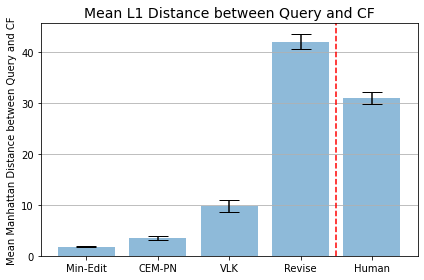

In [28]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Manhattan Distance between Query and CF', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Mean L1 Distance between Query and CF', fontsize = 14)
ax.yaxis.grid(True)

plt.axvline(x = 3.5, color = 'r', linestyle= '--')

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.pdf')
plt.show()

#### Euclidean Plots

In [29]:
aluminum_mean = np.array(l2_nun_cf).mean()
copper_mean = np.array(l2_proto_cf).mean()
steel_mean = np.array(mean_l2).mean()
gold_mean = np.array(mean_l2_g2).mean()
iron_mean = np.array(l2_wachter_cf).mean()
tin_mean = np.array(l2_cem_cf).mean()
revise_mean = np.array(l2_revise_cf).mean()



aluminum_sem = scipy.stats.sem(np.array(l2_nun_cf))
copper_sem = scipy.stats.sem(np.array(l2_proto_cf))
steel_sem = scipy.stats.sem(np.array(mean_l2))
gold_sem = scipy.stats.sem(np.array(mean_l2_g2))
iron_sem = scipy.stats.sem(np.array(l2_wachter_cf))
tin_sem = scipy.stats.sem(np.array(l2_cem_cf))
revise_sem = scipy.stats.sem(np.array(l2_revise_cf))

In [30]:
gold_mean

3.3805479130858465

In [31]:
materials = ['Min-Edit', 'CEM-PN', 'VLK', 'Revise', 'Human']
x_pos = np.arange(len(materials))
CTEs = [iron_mean, tin_mean, copper_mean, revise_mean, steel_mean]
error = [iron_sem, tin_sem, copper_sem, revise_sem, steel_sem]

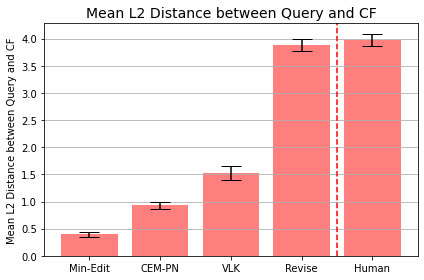

In [32]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color='red')
ax.set_ylabel('Mean L2 Distance between Query and CF', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Mean L2 Distance between Query and CF', fontsize = 14)
ax.yaxis.grid(True)

plt.axvline(x = 3.5, color = 'r', linestyle= '--')
# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars_euclidean.pdf')
plt.show()

#### Anova Testing with holm adjustment

In [33]:
import scipy.stats as stats
import scikit_posthocs as sp

##### L1 - Manhatten Distance

In [34]:
#fvalue, pvalue = stats.f_oneway(np.array(l1_wachter_cf), np.array(l1_cem_cf), np.array(l1_proto_cf),
#                                np.array(mean_l1),np.array(mean_l1_g2),np.array(l1_revise_cf))
#print(fvalue, pvalue)

In [35]:
fvalue, pvalue = stats.f_oneway(np.array(l1_wachter_cf), np.array(l1_cem_cf), np.array(l1_proto_cf),
                                np.array(mean_l1), np.array(l1_revise_cf))
print(fvalue, pvalue)

331.8053132367962 1.3142165648777758e-97


In [36]:
sp.posthoc_conover([np.array(l1_wachter_cf), np.array(l1_cem_cf), np.array(l1_proto_cf),
                                np.array(mean_l1),np.array(l1_revise_cf)], p_adjust='holm')

,1,2,3,4,5
1,1.000000e+00,3.473416e-04,4.962220e-16,1.223931e-52,2.925997e-68
2,3.473416e-04,1.000000e+00,8.738446e-07,1.739614e-40,7.611792e-57
3,4.962220e-16,8.738446e-07,1.000000e+00,7.145355e-23,2.299800e-39
4,1.223931e-52,1.739614e-40,7.145355e-23,1.000000e+00,3.077233e-06
5,2.925997e-68,7.611792e-57,2.299800e-39,3.077233e-06,1.000000e+00


##### L2 - Euclidean Distance

In [37]:
fvalue, pvalue = stats.f_oneway(np.array(l2_wachter_cf), np.array(l2_cem_cf), np.array(l2_proto_cf),
                                np.array(mean_l2),np.array(l2_revise_cf))
print(fvalue, pvalue)

314.13840171229964 3.644051400397814e-95


In [38]:
sp.posthoc_conover([np.array(l2_wachter_cf), np.array(l2_cem_cf), np.array(l2_proto_cf),
                                np.array(mean_l2),np.array(l2_revise_cf)], p_adjust='holm')

,1,2,3,4,5
1,1.000000e+00,1.182753e-08,4.972095e-19,2.541013e-65,3.774544e-63
2,1.182753e-08,1.000000e+00,3.862571e-04,1.653271e-45,3.610290e-43
3,4.972095e-19,3.862571e-04,1.000000e+00,9.471447e-33,1.972536e-30
4,2.541013e-65,1.653271e-45,9.471447e-33,1.000000e+00,4.798065e-01
5,3.774544e-63,3.610290e-43,1.972536e-30,4.798065e-01,1.000000e+00


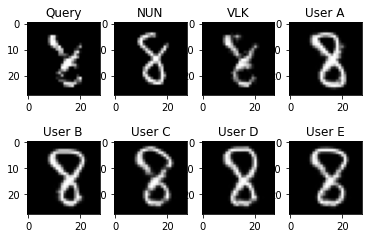

In [39]:
f, axarr = plt.subplots(nrows=2,ncols=4)
plt.sca(axarr[0,0]); 
plt.imshow(misclassified_user_sample[43]); plt.title('Query')
plt.sca(axarr[0,1]); 
plt.imshow(nun_counterfactual_user[43]); plt.title('NUN')
plt.sca(axarr[0,2]); 
plt.imshow(proto_counterfactual_user[43]); plt.title('VLK'); 
plt.sca(axarr[0,3]); 
plt.imshow(user_explanations[0][43]); plt.title('User A'); 

plt.sca(axarr[1,0]); 
plt.imshow(user_explanations[1][43]); plt.title('User B'); 
plt.sca(axarr[1,1]); 
plt.imshow(user_explanations[2][43]); plt.title('User C'); 
plt.sca(axarr[1,2]); 
plt.imshow(user_explanations[3][43]); plt.title('User D'); 
plt.sca(axarr[1,3]); 
plt.imshow(user_explanations[4][43]); plt.title('User E'); 
plt.show()

In [40]:
user_mean_l1_g1 = []

for user in range(21):
    
    l1=[]
    
    for image in range(50):
        l1.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), user_explanations[user][image].flatten()))
        # l1.append(sum(abs(misclassified_user_sample[image].flatten() - user_explanations[user][image].flatten())))
    user_mean_l1_g1.append((np.mean(l1)))
    
user_mean_l1_g1 = np.array(user_mean_l1_g1)

In [41]:
user_mean_l1_g2 = []

for user in range(21):
    
    l1_g2=[]
    
    for image in range(50):
        l1_g2.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), user_explanations_g2[user][image].flatten()))
        #l1_g2.append(sum(abs(misclassified_user_sample[image].flatten() - user_explanations_g2[user][image].flatten())) / misclassified_user_sample[image].flatten().size)
    user_mean_l1_g2.append((np.mean(l1_g2)))
    
user_mean_l1_g2 = np.array(user_mean_l1_g2)

In [42]:
user_mean_l1_g1, user_mean_l1_g2

(array([33.324234, 25.035294, 29.69498 , 31.906584, 25.436783, 27.086826,
        31.304   , 27.08596 , 34.34667 , 29.561256, 25.238588, 49.61945 ,
        41.316788, 31.328943, 23.574743, 39.657097, 36.075294, 27.629253,
        30.900864, 22.644157, 28.81365 ], dtype=float32),
 array([24.62039 , 38.428   , 24.457884, 27.188862, 20.403843, 21.942432,
        32.035374, 18.980312, 27.953333, 19.851374, 19.959608, 20.172157,
        25.651768, 24.40353 , 21.622038, 24.289726, 20.394352, 18.997334,
        32.696075, 25.84455 , 31.858192], dtype=float32))

In [43]:
km_prototypes = np.load('prototypes_mnist_kmedoids.npy')

In [44]:
mmd_pixel_prototype_indices = np.load('../../../../../MMD-critic/prototype_indices_mmd_pixel_local.npy')
mmd_pixel_criticism_indices = np.load('../../../../../MMD-critic/criticism_indices_mmd_pixel_local.npy')

In [45]:
mmd_pixel_prototype_indices[0], mmd_pixel_criticism_indices[0]

(array([3847, 3031, 3805, 1627, 2188, 3472, 3136, 4582, 4550, 4629],
       dtype=int64),
 array([ 561, 1311, 5077, 4077,  303, 3226,  957, 5080, 3293, 5811],
       dtype=int64))

In [46]:
training_indices_mmd_proto = []
training_indices_mmd_criticism = []

for class_label in range(10):
    
    training_indices_mmd_proto.append([np.where(np.argmax(y_train,axis=1)==class_label)[0][index] for index in mmd_pixel_prototype_indices[class_label]])
    training_indices_mmd_criticism.append([np.where(np.argmax(y_train,axis=1)==class_label)[0][index] for index in mmd_pixel_criticism_indices[class_label]])

training_indices_mmd_proto = np.array(training_indices_mmd_proto)
training_indices_mmd_criticism = np.array(training_indices_mmd_criticism)


In [47]:
mmd_pixel_prototypes = []
mmd_pixel_criticisms = []

for class_label in range(10):
    
    mmd_pixel_prototypes.append([x_train[index] for index in training_indices_mmd_proto[class_label]])
    
    mmd_pixel_criticisms.append([x_train[index] for index in training_indices_mmd_criticism[class_label]])
    
mmd_pixel_prototypes = np.array(mmd_pixel_prototypes)
mmd_pixel_criticisms = np.array(mmd_pixel_criticisms)

In [48]:
mmd_pixel_prototypes.shape, mmd_pixel_criticisms.shape

((10, 10, 28, 28, 1), (10, 10, 28, 28, 1))

#### Distances

In [49]:
user_indices = np.load('user_indices_mnist.npy')

In [50]:
user_indices

array([ 259,  321,  445,  582,  717,  740,  882,  883, 1014, 1226, 1232,
       1260, 1364, 1393, 1621, 1681, 1878, 1901, 2070, 2148, 2293, 2414,
       2454, 2597, 2654, 3289, 3422, 3780, 3808, 3941, 4007, 4065, 4536,
       4571, 4740, 4823, 4860, 4956, 5937, 5997, 6571, 6576, 6597, 6625,
       6651, 8408, 9015, 9642, 9692, 9839], dtype=int64)

In [51]:
true_labels_user = np.array([np.argmax(y_test, axis=1)[index] for index in user_indices])

In [52]:
true_labels_user

array([6, 2, 6, 8, 0, 4, 9, 3, 6, 7, 9, 7, 8, 5, 0, 3, 8, 9, 7, 4, 9, 9,
       6, 5, 6, 8, 6, 4, 7, 4, 7, 0, 6, 6, 3, 9, 4, 8, 5, 5, 9, 7, 0, 8,
       0, 8, 7, 9, 9, 2], dtype=int64)

In [53]:
test_labels_user_images = true_labels_user

In [54]:
km_prototypes[6].shape

(10, 28, 28, 1)

In [55]:
user_explanations[0].shape

(50, 28, 28, 1)

In [56]:
def distance_proto(method):

    distances_min = []

    for image in range(50):

        distances = []
        for prototype in range(10):

            distances.append(scipy.spatial.distance.euclidean(method[image].flatten(), mmd_pixel_prototypes[test_labels_user_images[image]][prototype].flatten()))

        distances_min.append(np.array(distances).min())

    distances_min = np.array(distances_min)
    
    return distances_min
    

In [57]:
def distance_proto(image_set_a, image_set_b, distance_function):

    distances_min = []

    for image in range(50):

        distances = []
        for prototype in range(1):
            
            if distance_function == 'euclidean':
                
                distances.append(scipy.spatial.distance.euclidean(image_set_a[image].flatten(), image_set_b[test_labels_user_images[image]][prototype].flatten()))
                
            elif distance_function == 'manhattan':
                distances.append(scipy.spatial.distance.cityblock(image_set_a[image].flatten(), image_set_b[test_labels_user_images[image]][prototype].flatten()))
                
            elif distance_function =='ssim':
                distances.append(ssim(image_set_a[image].flatten(), image_set_b[test_labels_user_images[image]][prototype].flatten()))
                
        distances_min.append(np.array(distances).min())

    distances_min = np.array(distances_min)
    
    return distances_min
    

### CNN + MC Dropout

Lets use Monte Carlo Dropout to assess model uncertainty --- 

In [58]:
G1_centroids = np.load('G1_centroids.npy')
G2_centroids = np.load('G2_centroids.npy')

In [59]:
nun_cf_user = np.load('nun_cf_mnist_user.npy')
vlk_cf_user = np.load('proto_cf_mnist.npy')
revise_cf_user = np.load('../../../../../DeDUCE-master/DeDUCE-master/REVISE_cfe.npy')
jmsa_cf_user = np.load('../../../../../DeDUCE-master/DeDUCE-master/JMSA_cfe.npy')
rl_cf_user = np.load('../ICLR_22/cfe_RL.npy')

In [60]:
np.argmax(cnn_mc.predict(revise_cf_user.reshape(50,28,28,1)), axis=1)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


array([0, 7, 6, 3, 0, 4, 9, 3, 5, 1, 9, 1, 2, 3, 0, 7, 3, 4, 7, 9, 0, 1,
       5, 5, 1, 8, 6, 4, 7, 4, 7, 1, 8, 8, 9, 9, 4, 9, 5, 5, 9, 1, 3, 4,
       1, 5, 7, 7, 9, 7], dtype=int64)

In [61]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(100)):
    y_p = cnn_mc.predict(G1_centroids.reshape(50,28,28,1), batch_size=1)
    mc_predictions.append(y_p)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.79it/s]


In [62]:
np.array(mc_predictions).shape

(100, 50, 10)

In [63]:
mean_mc = []

std_mc = []

for image in range(50):
    
    softmax_prediction_label = []
    
    for sample in range(100):
        
        softmax_prediction_label.append(np.array(mc_predictions[sample][image][true_labels_user[image]]))
        
    mean_mc.append(np.array(softmax_prediction_label).mean())
    std_mc.append(np.array(softmax_prediction_label).std())
        
    
    


In [64]:
def Monte_Carlo_Uncertainty(cf_batch):
    
    mc_predictions = []
    
    for i in tqdm.tqdm(range(100)):
        
        y_p = cnn_mc.predict(cf_batch.reshape(50,28,28,1), batch_size=1)
        mc_predictions.append(y_p)
        
        
    mean_mc = []
    
    std_mc = []
    
    for image in range(50):
        
        softmax_prediction_label = []
        
        for sample in range(100):
            
            softmax_prediction_label.append(np.array(mc_predictions[sample][image][true_labels_user[image]]))
    
    mean_mc.append(np.array(softmax_prediction_label).mean())
    std_mc.append(np.array(softmax_prediction_label).std())
    
    
    return np.mean(mean_mc), np.mean(std_mc)
    
    
    

In [65]:
Monte_Carlo_Uncertainty(G1_centroids.reshape(50,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.01it/s]


(0.93950087, 0.10687759)

In [66]:
Monte_Carlo_Uncertainty(vlk_cf_user.reshape(50,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.00it/s]


(0.6550625, 0.3005127)

In [67]:
Monte_Carlo_Uncertainty(revise_cf_user.reshape(50,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.92it/s]


(0.32933915, 0.22924376)

In [68]:
Monte_Carlo_Uncertainty(wachter_cf.reshape(50,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.01it/s]


(0.61681277, 0.33323795)

In [69]:
Monte_Carlo_Uncertainty(cem_cf.reshape(50,28,28,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.69it/s]


(0.59396905, 0.32618773)

### R% Substiutability

Fitting a 1-NN Euclidean Classfier on the Generated Instances and testing on the test set. Comparing to the prototypes generated by MMD Critic. 

In [70]:
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier

Counter(true_labels_user)

Counter({6: 8, 2: 2, 8: 7, 0: 5, 4: 5, 9: 9, 3: 3, 7: 7, 5: 4})

In [71]:
mmd_pixel_prototypes[1][0:3]

array([[[[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        ...,

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]]],


       [[[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
      

In [72]:
def R_sub(method):
        
    image_set = (mmd_pixel_prototypes[1][0:3])
    label_set = (np.array([1,1,1]))
    
    image_set = np.append(image_set, method)
    label_set= np.append(label_set, true_labels_user)
    
    image_set = np.array(image_set).reshape(53, 28*28)
    
    label_set = np.array(label_set)
    
    
    neigh = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    neigh.fit(image_set, label_set)
    
    return neigh.predict(x_test.reshape(10000,28*28))
    
    
    

In [73]:
from sklearn.metrics import accuracy_score
prediction = R_sub(method = G1_centroids)
accuracy_score(prediction,np.argmax(y_test, axis=1))

0.3782

In [74]:
def R_sub_proto():
    

    
    image_set = []

    for i in range(10):

        image_set.append(mmd_pixel_prototypes[i][0:5])

    image_set = np.array(image_set).reshape(50,28*28)

    label_set = np.array([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9])

    neigh = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    neigh.fit(image_set, label_set)
    
    return neigh.predict(x_test.reshape(10000,28*28))
    
    

In [75]:
R_sub_proto()

array([7, 3, 1, ..., 9, 5, 6])

In [76]:
accuracy_score(R_sub_proto(),np.argmax(y_test, axis=1))

0.7557

In [77]:
np.where(true_labels_user == 8)[0]

array([ 3, 12, 16, 25, 37, 43, 45], dtype=int64)

In [78]:
def method_distance(item_set, method, class_label):
    
    l1_ = []
    
    l1_p = []
    
    for image in item_set:
        
        
        l1_.append(scipy.spatial.distance.cityblock(misclassified_user_sample[image].flatten(), method[image].flatten()))
        
        l1_p.append(scipy.spatial.distance.cityblock(mmd_pixel_prototypes[class_label][0].flatten(), method[image].flatten()))
        
    return np.array(l1_), np.array(l1_p)
    
    
    
    
    
    

In [79]:
l1_human, l1_p_human = method_distance(np.where(true_labels_user == 0)[0], G1_centroids,0)

In [80]:
l1_w, l1_p_w = method_distance(np.where(true_labels_user == 0)[0], wachter_cf,0)

In [81]:
l1_r, l1_p_r = method_distance(np.where(true_labels_user == 0)[0], revise_cf_user,0)

In [82]:
colors = ["red", "green", "purple"]
x = list(l1_human) + list(l1_w) + list(l1_r)
y = list(l1_p_human) + list(l1_p_w) + list(l1_p_r)
color_indices = [0, 0,0,0,0] + [1,1,1,1,1] + [2,2,2,2,2]

colormap = matplotlib.colors.ListedColormap(colors)

#plt.scatter(x, y, c=color_indices, cmap=colormap)

In [83]:
l1_r

array([50.826233, 33.567024, 63.68406 , 42.11518 , 41.92313 ],
      dtype=float32)

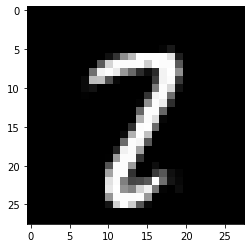

In [84]:
plt.imshow(cem_cf[1])

### Quantifying Image Blur Using A Laplacian Filter

In [85]:
from skimage.filters import laplace
import seaborn

In [86]:
human_var = []
vlk_var = []
revise_var = []

for image in range (50):
    
    revise_var.append(laplace(revise_cf_user[image], ksize=3).var())
    vlk_var.append(laplace(wachter_cf[image], ksize=3).var())
    human_var.append(laplace(G1_centroids[image], ksize=3).var())

Text(0, 0.5, 'Density')

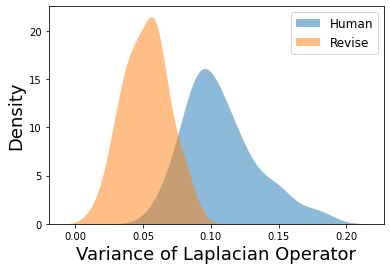

In [87]:
#seaborn.kdeplot(human_var, palette="crest")
#seaborn.kdeplot(revise_var, palette="crest")

seaborn.kdeplot(human_var,fill=True, common_norm=False, palette="crest",alpha=.5, linewidth=0, label='Human')
seaborn.kdeplot(revise_var,fill=True, common_norm=False, palette="crest",alpha=.5, linewidth=0, label='Revise')
plt.legend(fontsize=12)
plt.xlabel('Variance of Laplacian Operator', fontsize=18)
plt.ylabel('Density', fontsize=18)
#plt.savefig('blur_laplacian.pdf')

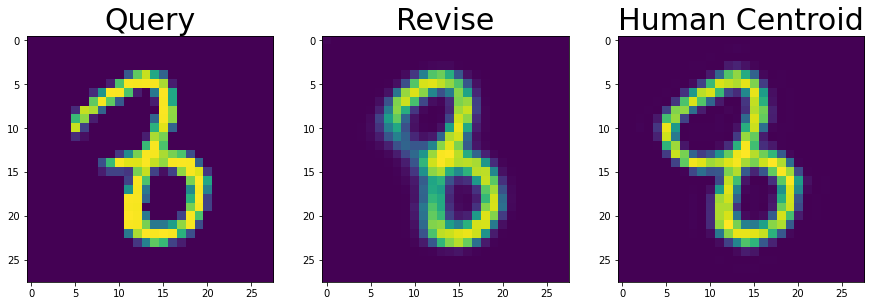

In [88]:
image_index = 16

f, axarr = plt.subplots(nrows=1,ncols=3, figsize=(15,15))
plt.sca(axarr[0]); 
plt.imshow(misclassified_user_sample[image_index], cmap='viridis'); plt.title('Query', fontsize=30)

plt.sca(axarr[1]); 
plt.imshow(revise_cf_user[image_index], cmap='viridis'); plt.title('Revise', fontsize = 30)

plt.sca(axarr[2]); 
plt.imshow(G1_centroids[image_index],cmap='viridis'); plt.title('Human Centroid', fontsize=30)
#plt.savefig('blur_example_0.pdf')
plt.show()

### 10-LOF

In [89]:
from sklearn.neighbors import LocalOutlierFactor

In [90]:
mmd_pixel_prototype_indices = np.load('../../../../../MMD-critic/prototype_indices_mmd_pixel_local_200.npy')
mmd_pixel_criticism_indices = np.load('../../../../../MMD-critic/criticism_indices_mmd_pixel_local_20.npy')

In [91]:
training_indices_mmd_proto = []
training_indices_mmd_criticism = []

for class_label in range(10):
    
    training_indices_mmd_proto.append([np.where(np.argmax(y_train,axis=1)==class_label)[0][index] for index in mmd_pixel_prototype_indices[class_label]])
    training_indices_mmd_criticism.append([np.where(np.argmax(y_train,axis=1)==class_label)[0][index] for index in mmd_pixel_criticism_indices[class_label]])

training_indices_mmd_proto = np.array(training_indices_mmd_proto)
training_indices_mmd_criticism = np.array(training_indices_mmd_criticism)

In [92]:
def LOF(label):
    
    image_set = []
    
    image_set.append([x_train[index] for index in training_indices_mmd_proto[label]])
    
    image_set.append([x_train[index] for index in training_indices_mmd_criticism[label]])
    
    image_set = np.vstack((np.array(image_set[0]), np.array(image_set[1]))).reshape(-1,28*28)
    
    clf = LocalOutlierFactor(novelty=True, n_neighbors=10, contamination=0.1, metric='l2')
    clf.fit(image_set)
    
    return clf

In [93]:
for technique in [wachter_cf, cem_cf, vlk_cf_user, revise_cf_user, G1_centroids]:

    values = []

    for label in [0,2,3,4,5,6,7,8,9]:

        Lof = LOF(label)

        values.append([Lof.decision_function(technique[i].reshape(1,28*28)) for i in np.where(true_labels_user==label)[0]])

    print(round(np.concatenate(values).ravel().mean(),3), round(stats.sem(np.concatenate(values).ravel()),3))

0.041 0.01
0.043 0.011
0.076 0.009
0.122 0.008
0.062 0.011


In [94]:
true_labels_user

array([6, 2, 6, 8, 0, 4, 9, 3, 6, 7, 9, 7, 8, 5, 0, 3, 8, 9, 7, 4, 9, 9,
       6, 5, 6, 8, 6, 4, 7, 4, 7, 0, 6, 6, 3, 9, 4, 8, 5, 5, 9, 7, 0, 8,
       0, 8, 7, 9, 9, 2], dtype=int64)

In [95]:
revise_cf_user.shape

(50, 28, 28)

#### Intuitive examples (using decision function)

In [96]:
Lof = LOF(4)

In [97]:
Lof.decision_function(cem_cf[29].reshape(-1,28*28)), Lof.predict(cem_cf[29].reshape(-1,28*28))

(array([-0.01608548]), array([-1]))

In [98]:
Lof.decision_function(G1_centroids[29].reshape(-1,28*28)), Lof.predict(G1_centroids[29].reshape(-1,28*28))

(array([0.03100263]), array([1]))

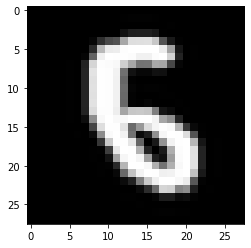

In [99]:
plt.imshow(G1_centroids[32])

In [100]:
np.array(values[0]).flatten()

array([-0.00597457,  0.11853167, -0.06364979, -0.10194751, -0.04450535])

### Proximity User Study Plots

In [101]:
materials = ['Human \n Natural', 'Human \n Instructed']
x_pos = np.arange(len(materials))
CTEs = [np.mean(mean_l1), np.mean(mean_l1_g2)]
error = [stats.sem(mean_l1), stats.sem(mean_l1_g2)]

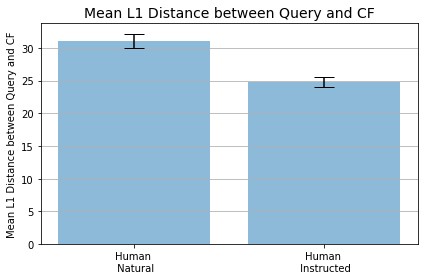

In [102]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean L1 Distance between Query and CF', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Mean L1 Distance between Query and CF', fontsize = 14)
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('human_l1.pdf')
plt.show()

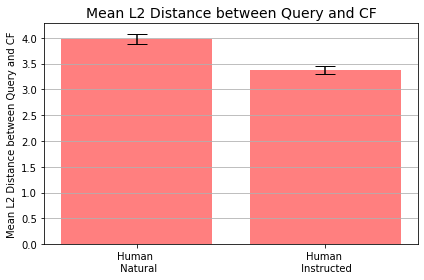

In [103]:
materials = ['Human \n Natural', 'Human \n Instructed']
x_pos = np.arange(len(materials))
CTEs = [np.mean(mean_l2), np.mean(mean_l2_g2)]
error = [stats.sem(mean_l2), stats.sem(mean_l2_g2)]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color = 'red')
ax.set_ylabel('Mean L2 Distance between Query and CF', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Mean L2 Distance between Query and CF', fontsize = 14)
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('human_l2.pdf')
plt.show()